<a href="https://colab.research.google.com/github/glhr/uncertainty-notebooks/blob/main/pretrained_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
!pip install torch torchvision

# # Install additional dependencies
!pip install transformers datasets evaluate matplotlib pillow scikit-learn

## Importing the Required Dependencies

In [2]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import requests
from transformers import AutoModelForSemanticSegmentation
from transformers import AutoImageProcessor
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get predictions from a pre-trained segmentation model

We'll be working with pre-trained segmentation models from [HuggingFace](https://huggingface.co) - that way we can focus on uncertainty-related concepts & minimal time on training/eval loops. I've selected the ADE20K scene segmentation dataset since it's available on HuggingFace as well: https://huggingface.co/datasets/scene_parse_150.
If you'd rather work with a different dataset or task (e.g. depth estimation or classification), feel free to go rogue and adapt the code.

## Let's define some helper functions

In [3]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_image_from_url(url):
  """downloads an image and converts it into a PIL image"""
  image = Image.open(requests.get(url, stream=True).raw)
  return image

def get_model_from_checkpoint(checkpoint="nvidia/segformer-b1-finetuned-cityscapes-1024-1024"):
  """loads a model from hugginface"""
  if "segformer" in checkpoint:
    image_processor = SegformerImageProcessor.from_pretrained(checkpoint)
    model = SegformerForSemanticSegmentation.from_pretrained(checkpoint)
  else: raise NotImplementedError # add other models here
  return model, image_processor

def get_prediction_for_image(image, model, image_processor):
  """outputs pixel-wise segmentation labels and max. softmax score for a PIL image"""

  encoding = image_processor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.to(device)

  outputs = model(pixel_values=pixel_values)
  softmax_logits = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu()

  upsampled_logits = nn.functional.interpolate(
      softmax_logits,
      size=image.size[::-1],
      mode="bilinear",
      align_corners=False,
  )

  pred_cls = upsampled_logits.argmax(dim=1)[0]
  pred_softmax = upsampled_logits.max(dim=1)[0]

  #print(pred_softmax)
  return pred_cls, pred_softmax



def ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([[0, 0, 0],[120, 120, 120],[180, 120, 120],[6, 230, 230],[80, 50, 50],[4, 200, 3],[120, 120, 80],[140, 140, 140],[204, 5, 255],[230, 230, 230],[4, 250, 7],[224, 5, 255],[235, 255, 7],[150, 5, 61],[120, 120, 70],[8, 255, 51],[255, 6, 82],[143, 255, 140],[204, 255, 4],[255, 51, 7],[204, 70, 3],[0, 102, 200],[61, 230, 250],[255, 6, 51],[11, 102, 255],[255, 7, 71],[255, 9, 224],[9, 7, 230],[220, 220, 220],[255, 9, 92],[112, 9, 255],[8, 255, 214],[7, 255, 224],[255, 184, 6],[10, 255, 71],[255, 41, 10],[7, 255, 255],[224, 255, 8],[102, 8, 255],[255, 61, 6],[255, 194, 7],[255, 122, 8],[0, 255, 20],[255, 8, 41],[255, 5, 153],[6, 51, 255],[235, 12, 255],[160, 150, 20],[0, 163, 255],[140, 140, 140],[250, 10, 15],[20, 255, 0],[31, 255, 0],[255, 31, 0],[255, 224, 0],[153, 255, 0],[0, 0, 255],[255, 71, 0],[0, 235, 255],[0, 173, 255],[31, 0, 255],[11, 200, 200],[255, 82, 0],[0, 255, 245],[0, 61, 255],[0, 255, 112],[0, 255, 133],[255, 0, 0],[255, 163, 0],[255, 102, 0],[194, 255, 0],[0, 143, 255],[51, 255, 0],[0, 82, 255],[0, 255, 41],[0, 255, 173],[10, 0, 255],[173, 255, 0],[0, 255, 153],[255, 92, 0],[255, 0, 255],[255, 0, 245],[255, 0, 102],[255, 173, 0],[255, 0, 20],[255, 184, 184],[0, 31, 255],[0, 255, 61],[0, 71, 255],[255, 0, 204],[0, 255, 194],[0, 255, 82],[0, 10, 255],[0, 112, 255],[51, 0, 255],[0, 194, 255],[0, 122, 255],[0, 255, 163],[255, 153, 0],[0, 255, 10],[255, 112, 0],[143, 255, 0],[82, 0, 255],[163, 255, 0],[255, 235, 0],[8, 184, 170],[133, 0, 255],[0, 255, 92],[184, 0, 255],[255, 0, 31],[0, 184, 255],[0, 214, 255],[255, 0, 112],[92, 255, 0],[0, 224, 255],[112, 224, 255],[70, 184, 160],[163, 0, 255],[153, 0, 255],[71, 255, 0],[255, 0, 163],[255, 204, 0],[255, 0, 143],[0, 255, 235],[133, 255, 0],[255, 0, 235],[245, 0, 255],[255, 0, 122],[255, 245, 0],[10, 190, 212],[214, 255, 0],[0, 204, 255],[20, 0, 255],[255, 255, 0],[0, 153, 255],[0, 41, 255],[0, 255, 204],[41, 0, 255],[41, 255, 0],[173, 0, 255],[0, 245, 255],[71, 0, 255],[122, 0, 255],[0, 255, 184],[0, 92, 255],[184, 255, 0],[0, 133, 255],[255, 214, 0],[25, 194, 194],[102, 255, 0],[92, 0, 255]])

def ade20k_label_namemap():
  """Given a segmentation label, returns the corresponding class name"""
  csv_url = "https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv"
  df=pd.read_csv(csv_url)
  #print(df.head())
  label_to_name = dict(zip(df["Idx"].apply(int), df["Name"]))
  label_to_name[0] = "other objects"
  label_to_name[-1] = "unlabelled"

  return label_to_name

def cls_seg_to_color(cls_seg, label_colormap, image=None):
  """converts a 1-channel image with segmentation labels to a 3-channel image with unique color for each class"""
  color_seg = np.zeros((cls_seg.shape[0], cls_seg.shape[1], 3), dtype=np.uint8)
  palette = np.array(label_colormap)
  for label, color in enumerate(palette):
      color_seg[cls_seg == label, :] = color
  color_seg[cls_seg == -1, :] = [255, 255, 255]
  color_seg = color_seg[..., ::-1]  # convert to BGR

  if image is not None:
    # overlay the segmentation mask on the image
    img_seg = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img_seg = img_seg.astype(np.uint8)

    return img_seg

  return color_seg

def visualize_predictions(pred_seg, pred_softmax, image, label_colormap=ade20k_label_colormap(), gt=None):
  """plots the input image, prediction, softmax scores (and optionally ground truth and error map) side-by-side"""
  img_seg = cls_seg_to_color(pred_seg, label_colormap)

  if gt is not None:
    gt_seg = cls_seg_to_color(gt, label_colormap)
    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(20,3))
    ax3.imshow(gt_seg)
    ax3.set_title('Ground truth')

    error_map = (gt.long() == pred_seg.long())
    ax4.imshow(error_map, vmin=0, vmax=1, cmap="Greys")
    ax4.set_title('Error map')
  else:
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12,3))

  ax0.imshow(image)
  ax0.set_title('Input image')

  ax1.imshow(img_seg)
  ax1.set_title('Class predictions')

  im = ax2.imshow(pred_softmax.squeeze(), vmin=0, vmax=1, cmap="Greys")
  ax2.set_title('Softmax scores')
  plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)
  plt.show()

## Loading a pre-trained segmentation model

In [4]:
model, image_processor = get_model_from_checkpoint(checkpoint="nvidia/segformer-b0-finetuned-ade-512-512")

# note: feel free to experiment with other models
# see https://huggingface.co/models?pipeline_tag=image-segmentation&sort=trending&search=scene_parse_150

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## Visualize predictions on known dataset

- Predicted ['other objects', 'wall', 'building;edifice', 'floor;flooring', 'windowpane;window', 'mountain;mount', 'shelf', 'grandstand;covered;stand']
- Ground truth: ['other objects', 'wall', 'building;edifice', 'sky', 'tree', 'road;route', 'grass', 'plant;flora;plant;life']


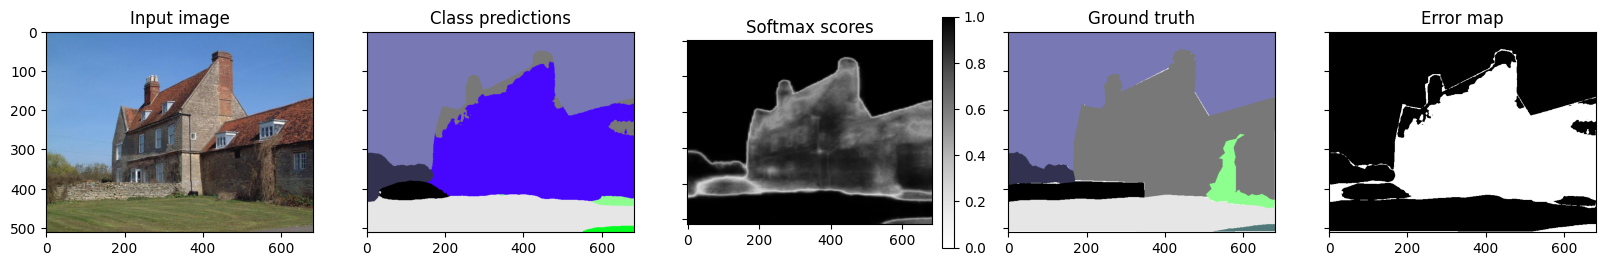

- Predicted ['other objects', 'wall', 'building;edifice', 'floor;flooring', 'truck;motortruck']
- Ground truth: ['other objects', 'wall', 'building;edifice', 'sky', 'tree', 'earth;ground', 'plant;flora;plant;life']


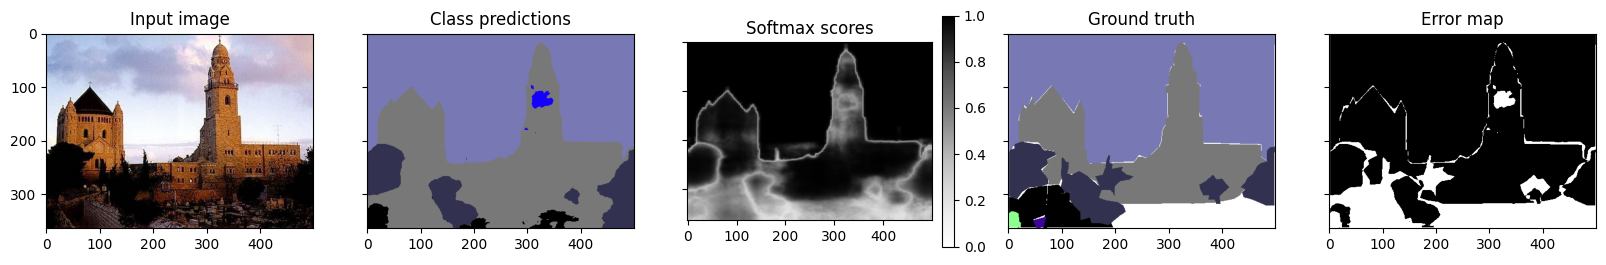

- Predicted ['wall', 'building;edifice', 'floor;flooring', 'ceiling', 'windowpane;window', 'cabinet', 'chair', 'seat', 'river', 'hovel;hut;hutch;shack;shanty', 'light;light;source', 'awning;sunshade;sunblind', 'apparel;wearing;apparel;dress;clothes', 'stage']
- Ground truth: ['other objects', 'wall', 'building;edifice', 'sky', 'tree', 'road;route', 'sidewalk;pavement', 'car;auto;automobile;machine;motorcar', 'signboard;sign', 'bus;autobus;coach;charabanc;double-decker;jitney;motorbus;motorcoach;omnibus;passenger;vehicle', 'streetlight;street;lamp', 'escalator;moving;staircase;moving;stairway', 'van']


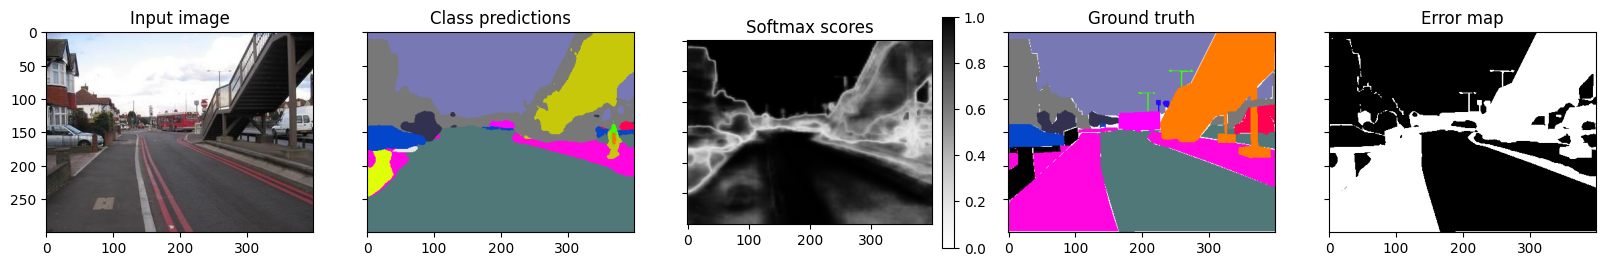

- Predicted ['building;edifice', 'floor;flooring', 'ceiling', 'windowpane;window', 'sidewalk;pavement', 'table', 'chair', 'stairs;steps', 'television;television;receiver;television;set;tv;tv;set;idiot;box;boob;tube;telly;goggle;box', 'washer;automatic;washer;washing;machine', 'bag']
- Ground truth: ['other objects', 'sky', 'tree', 'grass', 'person;individual;someone;somebody;mortal;soul', 'mountain;mount', 'car;auto;automobile;machine;motorcar', 'runway', 'airplane;aeroplane;plane']


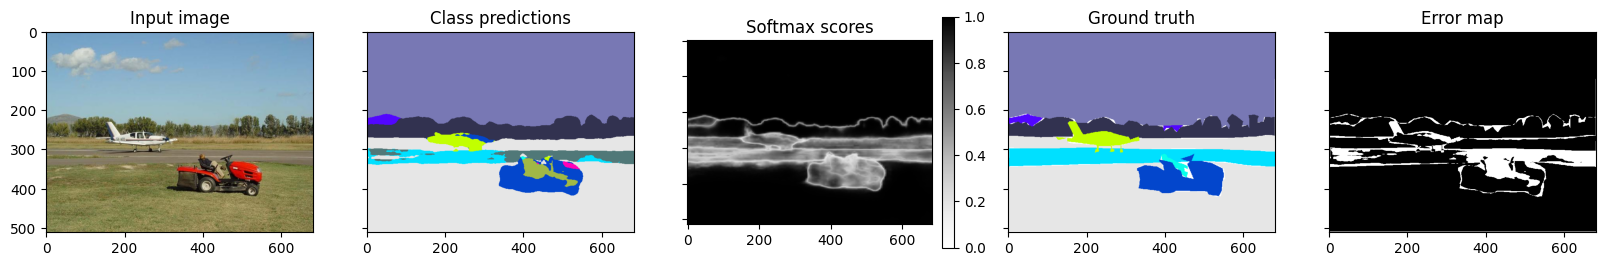

- Predicted ['other objects', 'sky', 'tree', 'sidewalk;pavement', 'armchair']
- Ground truth: ['other objects', 'wall', 'floor;flooring', 'ceiling', 'person;individual;someone;somebody;mortal;soul', 'table', 'curtain;drape;drapery;mantle;pall', 'seat']


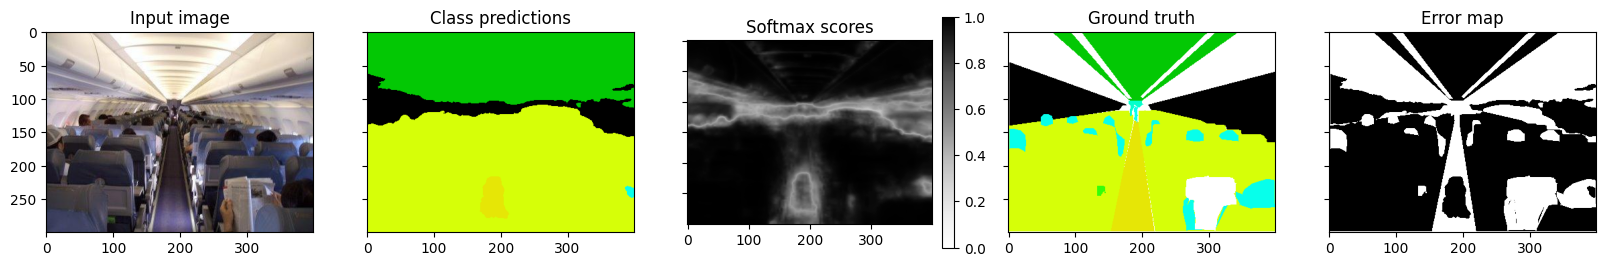

In [8]:
ds = load_dataset("scene_parse_150", split="validation", streaming=True, trust_remote_code=True) # note: by using streaming=True we avoid downloading the full dataset
ds_iterable = iter(ds)

label_to_name = ade20k_label_namemap()

for _ in range(5): # iterate through the first 3 images in the test set
  ds_sample = next(ds_iterable)
  image = ds_sample["image"]
  gt = torch.from_numpy(np.asarray(ds_sample["annotation"]))


  # get and visualize predictions
  pred_cls, pred_softmax = get_prediction_for_image(image,model, image_processor)
  print(f"- Predicted {[label_to_name[l.item()] for l in torch.unique(pred_cls)]}\n- Ground truth: {[label_to_name[l.item()] for l in torch.unique(gt)]}")
  visualize_predictions(pred_cls, pred_softmax, image, gt=gt-1)

  # Refer to this file for the information about the labels of the 150 semantic categories, including indices, pixel ratios and names: https://github.com/CSAILVision/sceneparsing/blob/master/objectInfo150.csv
  # note: Note: annotation masks contain labels ranging from 0 to 150, where 0 refers to "other objects". Those pixels are not considered in the official evaluation.
  # GT pixels with value -1 were not annotated (thus should not be considered in eval either)


# Exercise 1: Implement an uncertainty evaluation metric

Compare the softmax scores with the error map. To what extent is the softmax score a good indicator that the model is making a mistake?

To quantify this, implement a scoring rule, a calibration-based metric or a detection-based metric.
Tip: you can use functions from scikit-learn e.g. [Brier score](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss), [calibration curve implementation](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html#sklearn.calibration.CalibrationDisplay.from_predictions) and [ROC-AUC](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

# Exercise 2: making the model fail harder

Browse through example images and the list of categories in the ADE20K dataset here: https://groups.csail.mit.edu/vision/datasets/ADE20K/ (scroll down the page). Based on this, experiment with feeding the model different kinds of out-of-distribution images. Is the softmax score reliable? How would you go about evaluating this, considering there is no ground truth for out-of-distribution images?

Below is some code which you can use to get predictions on a list of image URLS:

- Predicted ['other objects', 'building;edifice', 'floor;flooring', 'tree', 'sidewalk;pavement', 'table', 'car;auto;automobile;machine;motorcar']


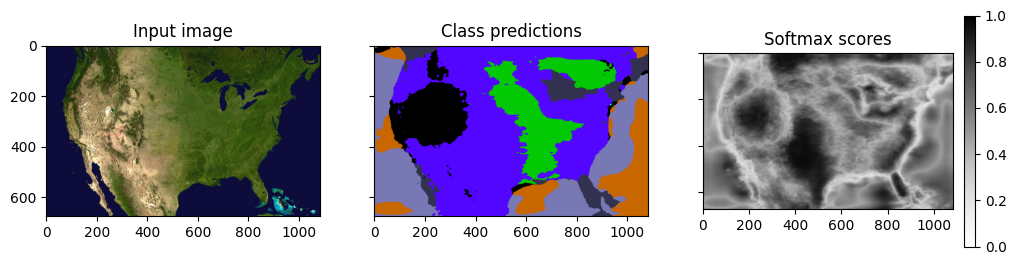

In [6]:
image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/0/03/USA-satellite.jpg"
    # experiment with other images here
]

for image_url in image_urls:
  image = get_image_from_url(url=image_url)
  pred_cls, pred_softmax = get_prediction_for_image(image,model, image_processor)
  print(f"- Predicted {[label_to_name[l.item()] for l in torch.unique(pred_cls)]}")
  visualize_predictions(pred_cls, pred_softmax, image)

# Exercise 3: better uncertainty with ensembles

Your task is now to try and obtain better uncertainty estimates, still leveraging existing pre-trained models.
* Implement an ensemble of at least 3 different models trained on this dataset (you can search for models here: https://huggingface.co/models?pipeline_tag=image-segmentation&sort=trending&search=scene_parse_150). Note: you might need to modify `get_model_from_checkpoint` & `get_prediction_for_image` depending on which model you pick.
* Compare their predictions on some samples from the validation set vs. some out-of-distribution samples.
* Based on the lecture slides, pick an uncertainty measure which aims to capture epistemic uncertainty based on the ensemble predictions. Compute and visualize it. Note: you will need to modify `get_prediction_for_image()`.

To get you started, here are predictions from 2 different models on an out-of-distribution image.

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


- Model 1 Predicted ['other objects', 'building;edifice', 'floor;flooring', 'tree', 'sidewalk;pavement', 'table', 'car;auto;automobile;machine;motorcar']


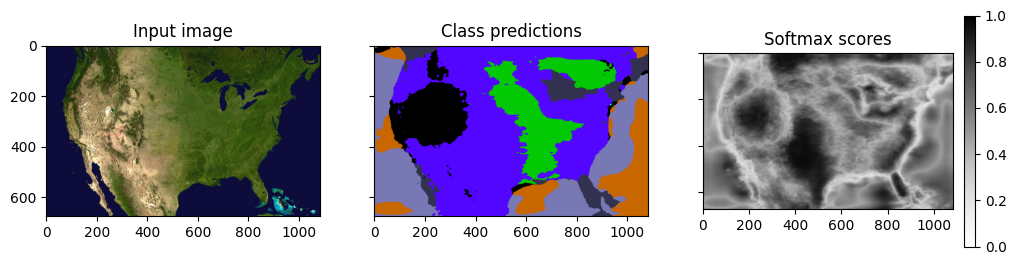

- Model 2 Predicted ['other objects', 'floor;flooring', 'sidewalk;pavement', 'car;auto;automobile;machine;motorcar']


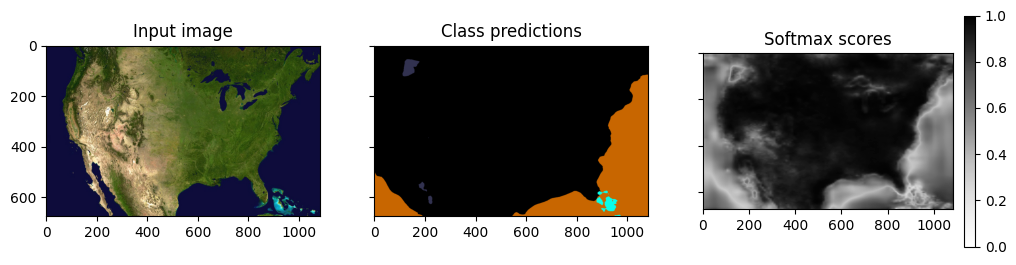

In [7]:
model1, image_processor1 = get_model_from_checkpoint(checkpoint="nvidia/segformer-b0-finetuned-ade-512-512")
model2, image_processor2 = get_model_from_checkpoint(checkpoint='nvidia/segformer-b3-finetuned-ade-512-512')

for image_url in image_urls:
  image = get_image_from_url(url=image_url)

  pred_cls, pred_softmax = get_prediction_for_image(image,model1, image_processor1)
  print(f"- Model 1 Predicted {[label_to_name[l.item()] for l in torch.unique(pred_cls)]}")
  visualize_predictions(pred_cls, pred_softmax, image)

  pred_cls, pred_softmax = get_prediction_for_image(image,model2, image_processor2)
  print(f"- Model 2 Predicted {[label_to_name[l.item()] for l in torch.unique(pred_cls)]}")
  visualize_predictions(pred_cls, pred_softmax, image)